In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Diffuser Problem

## Computational Mesh

In [2]:
# Create Meshes for Diffuser Problem.
n_elem_for_width = 33
n_elem_for_height = 33
mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height, width=1., height=1., outlet_height=1./3.)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height, width=1., height=1., outlet_height=1./3.)

## Finite Element Model

### Boundary Conditions

In [3]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def outlet_velocity(mesh, i_node, width):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 0.0; v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # Parallel outflow, i.e., no vertical velocity.
            BC.append([node, 1, 0.0])
boundary_values_v = np.array(BC)

### Material Properties

In [6]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.002523994143500149


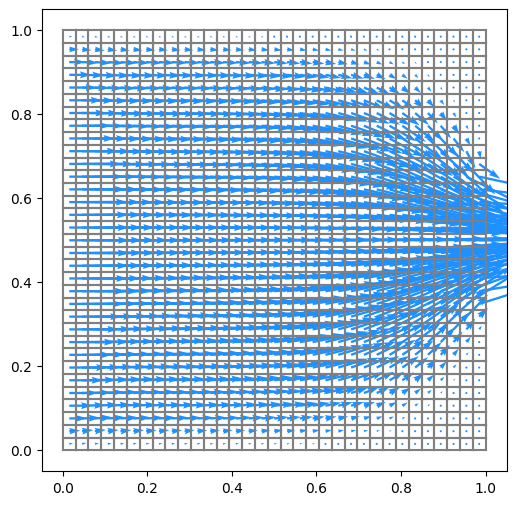

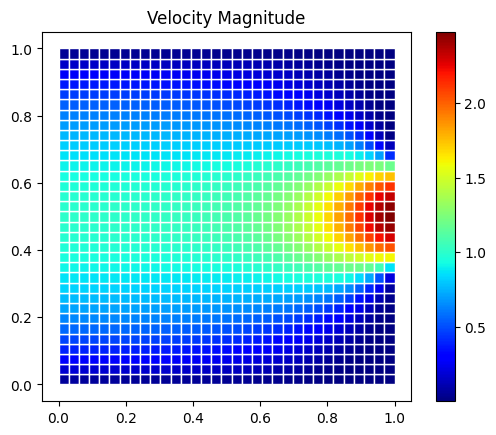

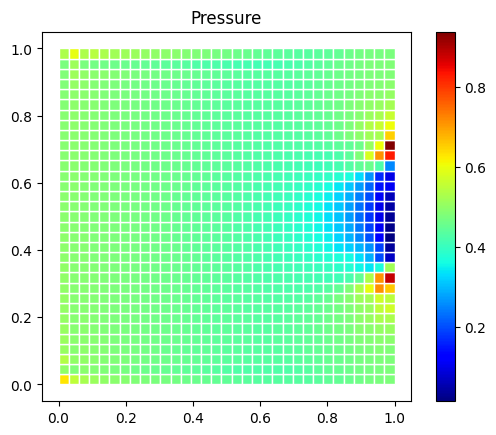

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [9]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
design_tolerance = 0.01 # Convergence tolerance on design variables.

active = {'classic': False,
          'annealing': True}

### Classical Optimization

In [10]:
density_initial = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values = [0.01, 0.1, 1.] #

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.002523994143500149, Volume Fraction: 0.7999999999999998
Iteration: 2, Objective Function: 0.012648604804587014, Volume Fraction: 0.6000000000000001
Iteration: 3, Objective Function: 0.02826625540870957, Volume Fraction: 0.500009541891229
Iteration: 4, Objective Function: 0.02982712066871502, Volume Fraction: 0.5000197594226815
Iteration: 5, Objective Function: 0.0197762870455258, Volume Fraction: 0.5000243201662485


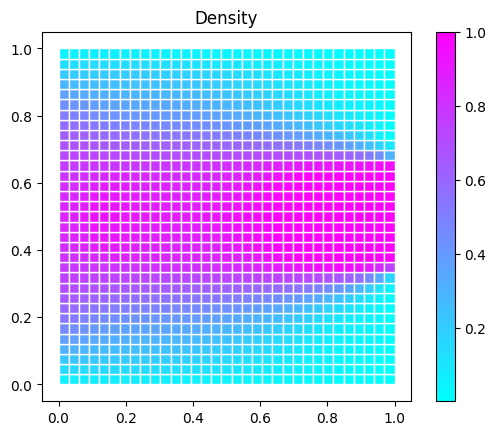

Iteration: 6, Objective Function: 0.01177946557661139, Volume Fraction: 0.5000314470782626
Iteration: 7, Objective Function: 0.007678533601144967, Volume Fraction: 0.49992494945204896
Iteration: 8, Objective Function: 0.006747500602065746, Volume Fraction: 0.4999481814003064
Iteration: 9, Objective Function: 0.0064899286342407336, Volume Fraction: 0.5000189679165349
Iteration: 10, Objective Function: 0.006406741185314305, Volume Fraction: 0.49993925209084117


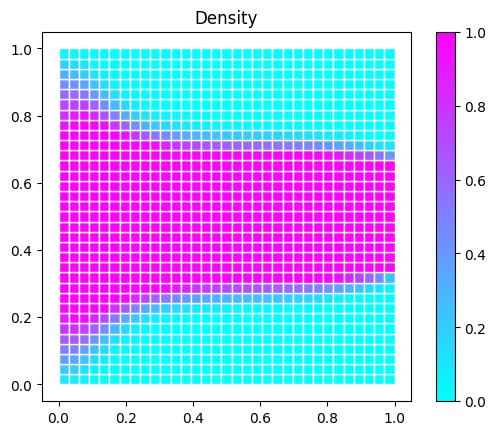

Iteration: 11, Objective Function: 0.006381059820739702, Volume Fraction: 0.5000643490898954
Iteration: 12, Objective Function: 0.006365386200727991, Volume Fraction: 0.49994277066391335
Iteration: 13, Objective Function: 0.006364772921425117, Volume Fraction: 0.4999374145799173


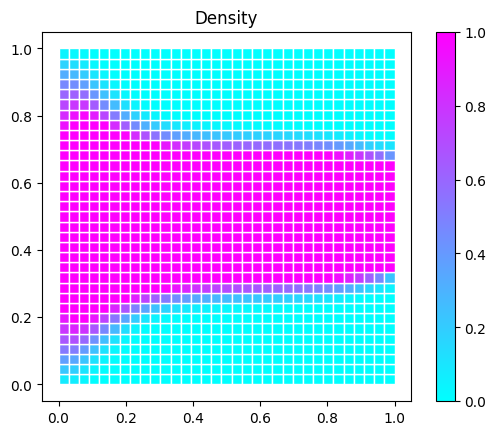

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.009834723637641972, Volume Fraction: 0.4999962240312157
Iteration: 2, Objective Function: 0.008598050687456227, Volume Fraction: 0.4999879027249295
Iteration: 3, Objective Function: 0.008272289095104943, Volume Fraction: 0.5000110372275817
Iteration: 4, Objective Function: 0.008199338167900846, Volume Fraction: 0.4999945730207451
Iteration: 5, Objective Function: 0.008178490918993774, Volume Fraction: 0.5000056575311544


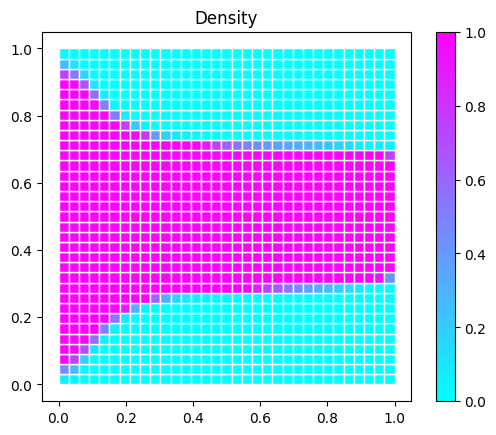

Iteration: 6, Objective Function: 0.008167646664375427, Volume Fraction: 0.5000002697767615
Iteration: 7, Objective Function: 0.008162141108265162, Volume Fraction: 0.499993943244502
Iteration: 8, Objective Function: 0.00815845439931883, Volume Fraction: 0.49998669714771893
Iteration: 9, Objective Function: 0.008155885428524683, Volume Fraction: 0.5000042243111593
Iteration: 10, Objective Function: 0.00815243074255546, Volume Fraction: 0.5000058701983567


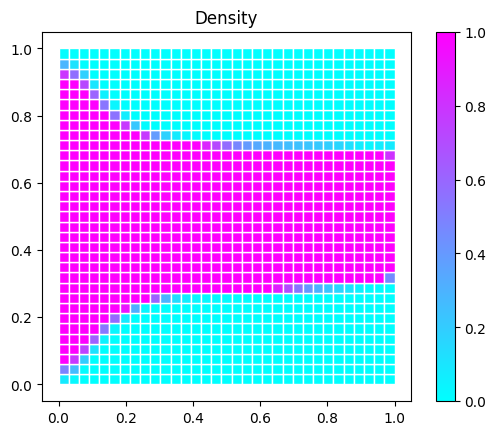

Iteration: 11, Objective Function: 0.008150114694554402, Volume Fraction: 0.5000085748246292
Iteration: 12, Objective Function: 0.008147975185625243, Volume Fraction: 0.49999957041045806
Iteration: 13, Objective Function: 0.008146500876299702, Volume Fraction: 0.4999973074558107
Iteration: 14, Objective Function: 0.008144723772022841, Volume Fraction: 0.4999935159646866
Iteration: 15, Objective Function: 0.008143159952962746, Volume Fraction: 0.5000083211635612


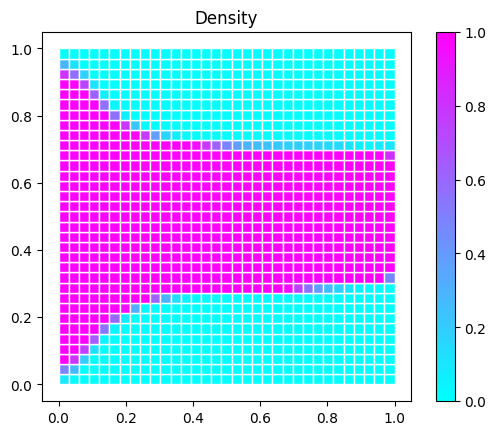

Iteration: 16, Objective Function: 0.008140663459198751, Volume Fraction: 0.4999946981413903
Iteration: 17, Objective Function: 0.008139630731453733, Volume Fraction: 0.4999933747657494
Iteration: 18, Objective Function: 0.008138040428867403, Volume Fraction: 0.5000025878636463
Iteration: 19, Objective Function: 0.008136039470037578, Volume Fraction: 0.5000086658118099
Iteration: 20, Objective Function: 0.008134275580039497, Volume Fraction: 0.49999388956319285


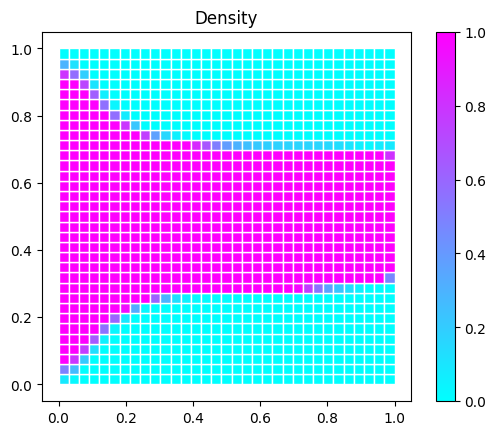

Iteration: 21, Objective Function: 0.008133643186865776, Volume Fraction: 0.4999923436710972
Iteration: 22, Objective Function: 0.00813236363987103, Volume Fraction: 0.4999946989318106
Iteration: 23, Objective Function: 0.00813106311248047, Volume Fraction: 0.49999071299757303
Iteration: 24, Objective Function: 0.008130208906874945, Volume Fraction: 0.5000051761622921
Iteration: 25, Objective Function: 0.008128478335001235, Volume Fraction: 0.5000120347474152


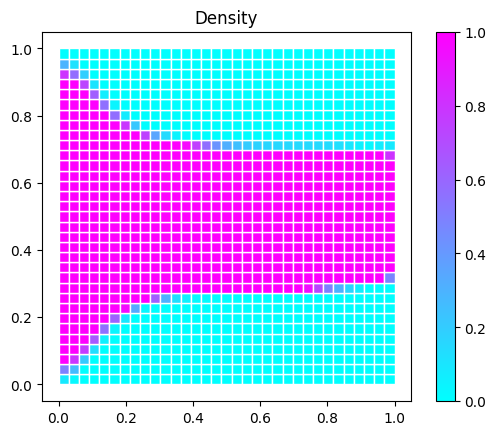

Iteration: 26, Objective Function: 0.008127194715734436, Volume Fraction: 0.49999192960091876
Iteration: 27, Objective Function: 0.008127343727591467, Volume Fraction: 0.5000021231123781
Iteration: 28, Objective Function: 0.008125964088525953, Volume Fraction: 0.499989137154549
Iteration: 29, Objective Function: 0.008125888354592999, Volume Fraction: 0.49999341299922445
Iteration: 30, Objective Function: 0.008125015393923012, Volume Fraction: 0.4999901285415414


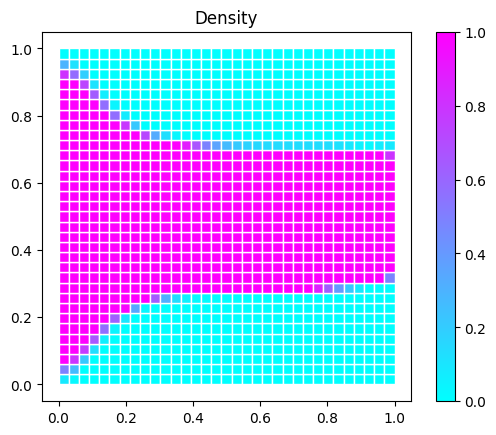

Iteration: 31, Objective Function: 0.008124603650680188, Volume Fraction: 0.5000068016885959
Iteration: 32, Objective Function: 0.008123228540083991, Volume Fraction: 0.49999302368762993
Iteration: 33, Objective Function: 0.008123471455008422, Volume Fraction: 0.5000052500793278
Iteration: 34, Objective Function: 0.0081224263948344, Volume Fraction: 0.49999025431218524
Iteration: 35, Objective Function: 0.008122821432648707, Volume Fraction: 0.500003176300995


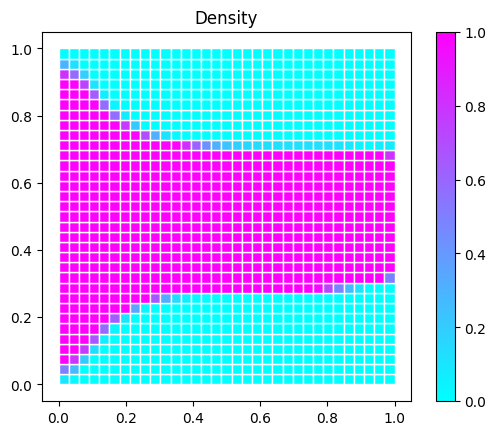

Iteration: 36, Objective Function: 0.008121820577732792, Volume Fraction: 0.49999005506751204
Iteration: 37, Objective Function: 0.008122190763824219, Volume Fraction: 0.5000056182025161
Iteration: 38, Objective Function: 0.008121117814991205, Volume Fraction: 0.4999932649664223
Iteration: 39, Objective Function: 0.00812150781532733, Volume Fraction: 0.4999951456611612
Iteration: 40, Objective Function: 0.008121211755918773, Volume Fraction: 0.49999162985511775


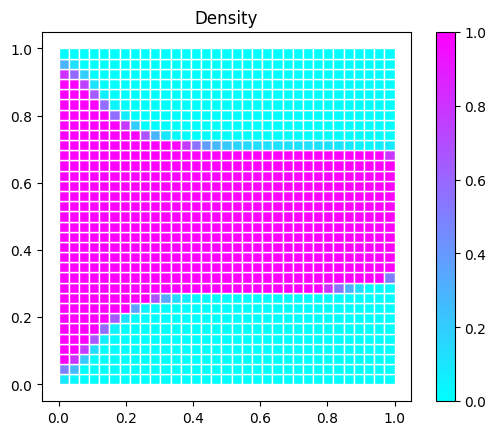

Iteration: 41, Objective Function: 0.008121225132646482, Volume Fraction: 0.5000066800484366
Iteration: 42, Objective Function: 0.008120313414668227, Volume Fraction: 0.4999929619388571


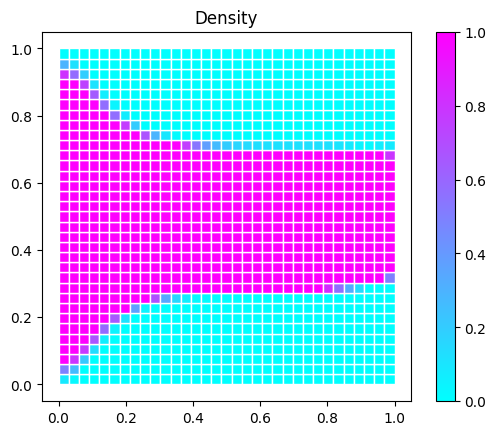

############### q = 1.0 ################
Iteration: 1, Objective Function: 0.008890578279101577, Volume Fraction: 0.4999967166628259
Iteration: 2, Objective Function: 0.00866303123654934, Volume Fraction: 0.4999971916733099
Iteration: 3, Objective Function: 0.008556480834384008, Volume Fraction: 0.5000024588133476
Iteration: 4, Objective Function: 0.008493585944633585, Volume Fraction: 0.5000009772545122
Iteration: 5, Objective Function: 0.008462807124822048, Volume Fraction: 0.4999984636756368


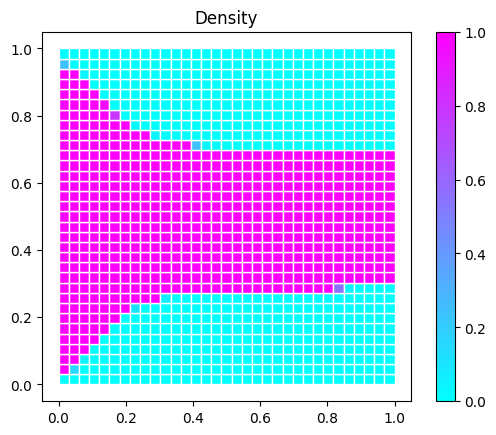

Iteration: 6, Objective Function: 0.008439774924935799, Volume Fraction: 0.49999990113611026
Iteration: 7, Objective Function: 0.008422519327594996, Volume Fraction: 0.5000001640577406
Iteration: 8, Objective Function: 0.008418205499837348, Volume Fraction: 0.5000003822537069
Iteration: 9, Objective Function: 0.008415972475001204, Volume Fraction: 0.5000007142867033
Iteration: 10, Objective Function: 0.008413649005579333, Volume Fraction: 0.5000006867026012


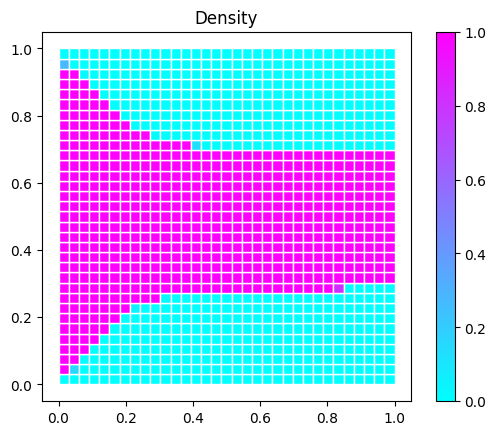

Iteration: 11, Objective Function: 0.008410935057585417, Volume Fraction: 0.5000006246489743
Iteration: 12, Objective Function: 0.008407299851485039, Volume Fraction: 0.5000000720405354
Iteration: 13, Objective Function: 0.008402446555836133, Volume Fraction: 0.500000074755589
Iteration: 14, Objective Function: 0.008402083404193678, Volume Fraction: 0.49999981105541885
Iteration: 15, Objective Function: 0.008401793660996021, Volume Fraction: 0.49999988631485576


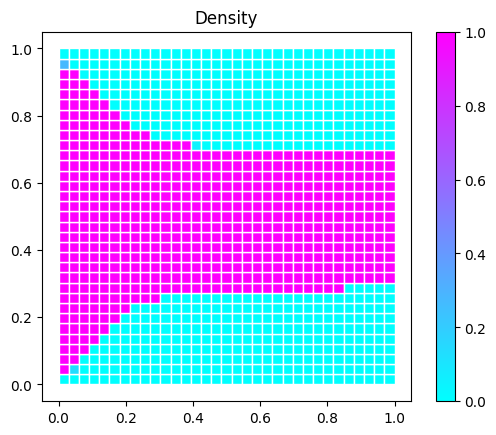

Iteration: 16, Objective Function: 0.008401536373602692, Volume Fraction: 0.49999991107897296
Iteration: 17, Objective Function: 0.008401323025562511, Volume Fraction: 0.5000001217308826


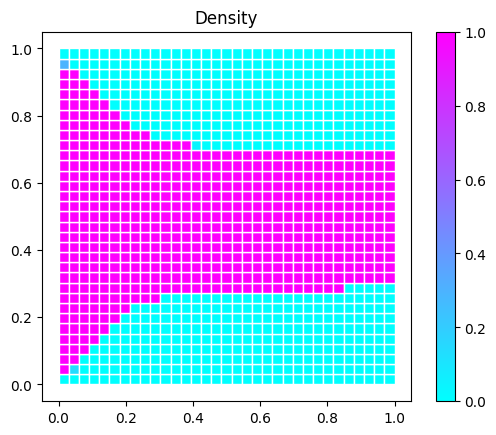

Final objective function (binary design): 0.008427115520866845, volume fraction 0.4995408631772268


In [11]:
poly_top = PolyTop(fem)
if active['classic']:
    density = poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                    design_tolerance, max_iterations, q_values,
                    opt_OCMove, opt_OCEta)
    
    binary_array = np.where(density >= 0.95, 1, 0)
    E = fem.viscosity/fem.epsilon*(1-binary_array)
    _, u, v, _, _, f = fem.solve(E)
    print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

### Optimization with Ising Machine Formulation

In [12]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [13]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9

hyperparameters = {
        'energy_dissipation': 2.e3,
        'regularization': 10.,
        'volume_constraint': 600.,
        'char_func': 300.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.022871788069941234, Volume Fraction: 0.5087235996326905, Inconsistencies: 0
Max. change: 1.0
Iteration: 1, Objective Function: 0.01131224308842071, Volume Fraction: 0.5013774104683195, Inconsistencies: 0
Max. change: 0.7777777777777778
Iteration: 2, Objective Function: 0.011017689690961705, Volume Fraction: 0.5004591368227732, Inconsistencies: 0
Max. change: 0.7777777777777777
Iteration: 3, Objective Function: 0.01070648245356233, Volume Fraction: 0.5004591368227732, Inconsistencies: 0
Max. change: 0.7777777777777778
Iteration: 4, Objective Function: 0.010377698770865416, Volume Fraction: 0.5004591368227732, Inconsistencies: 0
Max. change: 0.7777777777777778
Iteration: 5, Objective Function: 0.01042958297852315, Volume Fraction: 0.5004591368227732, Inconsistencies: 0
Max. change: 0.7777777777777777
Iteration: 6, Objective Function: 0.00988823545495288, Volume Fraction: 0.5004591368227732, Inconsistencies: 0
Max. change: 0.7777777777777778
Iteration: 

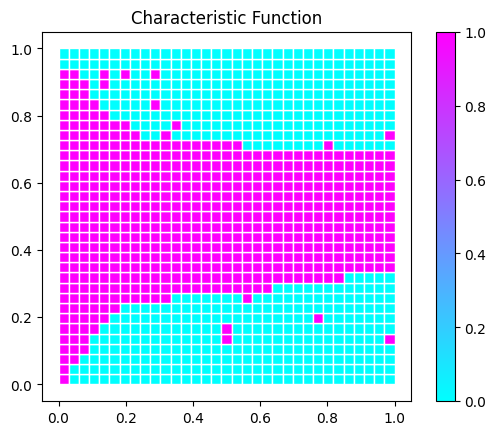

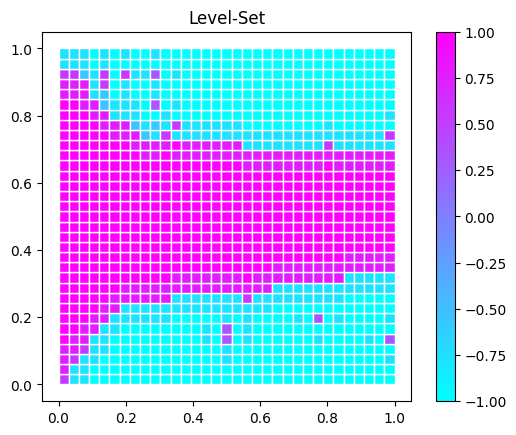

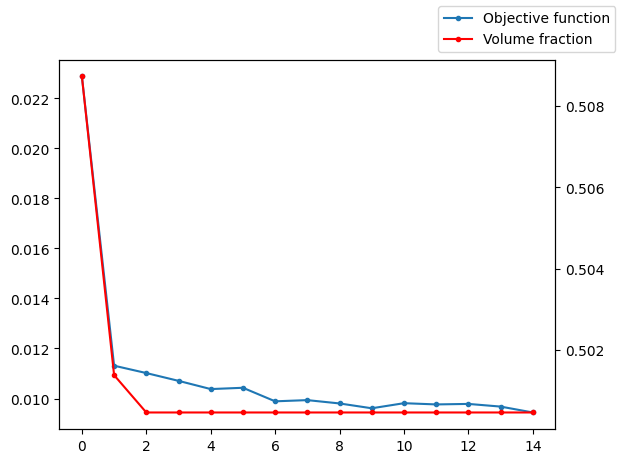

In [14]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)
if active['annealing']:
    annealing_optimizer.optimize(annealing_solver,
                                topo_opt_problem, 
                                level_set_scaled_initial,
                                max_opt_steps,
                                design_tolerance)
    annealing_optimizer.plot_history()